<a href="https://colab.research.google.com/github/Pablo-Lemos/orbits/blob/master/planets_graphnets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning planetary orbits

This notebook will attempt to use GraphNets to learn planetary orbits

# Code

In [0]:
#@title Imports  { form-width: "30%" }

import time
import sys

from graph_nets import blocks
from graph_nets import utils_np
from graph_nets import utils_tf
from graph_nets.demos import models
from matplotlib import pyplot as plt

import numpy as np
import networkx as nx
import sonnet as snt
import tensorflow as tf
import seaborn as sns

from google.colab import drive

SEED = 1
np.random.seed(SEED)
tf.set_random_seed(SEED)


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [0]:
#@title Plotting functions  { form-width: "30%" }

def plot_graphs_tuple_np(graphs_tuple):
  """ Plots a graph """

  networkx_graphs = utils_np.graphs_tuple_to_networkxs(graphs_tuple)
  num_graphs = len(networkx_graphs)
  _, axes = plt.subplots(1, num_graphs, figsize=(5*num_graphs, 5))
  if num_graphs == 1:
    axes = axes,
  for graph, ax in zip(networkx_graphs, axes):
    plot_graph_networkx(graph, ax)


def plot_graph_networkx(graph, ax, pos=None):
  """ Plots a networks graph """
  node_labels = {node: "{:.3g}".format(data["features"][0])
                 for node, data in graph.nodes(data=True)
                 if data["features"] is not None}
  edge_labels = {(sender, receiver): "{:.3g}".format(data["features"][0])
                 for sender, receiver, data in graph.edges(data=True)
                 if data["features"] is not None}
  global_label = ("{:.3g}".format(graph.graph["features"][0])
                  if graph.graph["features"] is not None else None)

  if pos is None:
    pos = nx.spring_layout(graph)
  nx.draw_networkx(graph, pos, ax=ax, labels=node_labels)

  if edge_labels:
    nx.draw_networkx_edge_labels(graph, pos, edge_labels, ax=ax)

  if global_label:
    plt.text(0.05, 0.95, global_label, transform=ax.transAxes)

  ax.yaxis.set_visible(False)
  ax.xaxis.set_visible(False)
  return pos

def get_node_trajectories(rollout_array, batch_size):  # pylint: disable=redefined-outer-name
  """Extract the trajectory as a numpy array"""
  return np.split(rollout_array[..., 1:3], batch_size, axis=1)


def get_node_velocities(rollout_array, batch_size):  # pylint: disable=redefined-outer-name
  """Extract the trajectory as a numpy array"""
  return np.split(rollout_array[..., 3:5], batch_size, axis=1)

def plot_trajectories(true_trajectory, test_trajectory, name = "None", 
                      iteration = 0, momenta = False, savename = "None"):
  """ Plots the real and simulated trajectories

  Parameters
  ----------
    true_trajectory: np.array
      array formed of X and Y components describing a trajectory
    test_trajectory: np.array
      array formed of X and Y components describing a trajectory
    name: str
      the name of the plot, if not "None", it is added to the plot as a title
    iteration: int
      the number of iterations used to obtain the test trajectory. If it's 
      bigger than zero, it is used as the plot title. Defaults to 0
  """

  nbodies = len(test_trajectory[0])
  fig = plt.figure()
  if momenta: 
      plt.xlabel('$P_x$')
      plt.ylabel('$P_y$')
  else:
      plt.xlabel('X [AU]')
      plt.ylabel('Y [AU]')
  
  title = ""

  if name is not "None":
    title += name

  if iteration > 0:
    title += 'iteration ' + str(iteration)

  plt.title(title)
  for i in range(nbodies):
    plt.plot(true_trajectory[:,i,0], true_trajectory[:,i,1], 
                label='Truth',
                color = 'k', marker = 'o')
    plt.plot(test_trajectory[:,i,0], test_trajectory[:,i,1],
                label='Test',
                marker = '.')
    if i == 0: 
      plt.legend()
  if savename is not "None":  
    plt.savefig(savename + '.pdf')
  plt.show()
    

In [0]:
#@title Helper functions  { form-width: "30%" }

def random_two_vector():
  """
  Generates a random 2D unitary vector

  Returns:
  --------
  x,y: float
      Coordinates of the unitary vector (x^2 + y^2 = 1)

  """
  phi = np.random.uniform(0,np.pi*2)
  x = np.cos(phi)
  y = np.sin(phi)
  return np.array([x,y])

def random_three_vector():
  """
  Generates a random 3D unitary vector

  Returns:
  --------
  x,y,z: float
      Coordinates of the unitary vector (x^2 + y^2 + z^2 = 1)

  """
  phi = np.random.uniform(0,np.pi*2)
  costheta = np.random.uniform(-1,1)
  theta = np.arccos( costheta )
  x = np.sin(theta) * np.cos(phi)
  y = np.sin(theta) * np.sin(phi)
  z = np.cos(theta )
  return np.array([x,y,z])

In [0]:
#@title Physics functions  { form-width: "30%" }

def get_orbital_velocity(radius, mass_planet, mass_star, G, noise = 0): 
  """Calculate the velocity required to keep an orbit

  Parameters
  ---------- 
  radius : float
    the radial distance from the body to the center of the orbit
  mass_planet : float
    mass of the planet orbiting
  mass_star : float
    mass of the body at the center of the orbit
  G : float 
    Gravitational Constant
  noise: float
    The maximum fractional amount by which the initial velocity is perturbed. 
    Defaults to zero

  Returns
  ---------- 
  velocity : float
    the orbital velocity

  """

  velocity = np.sqrt(G*mass_star/radius)

  # Add noise
  if noise > 0:
    delta_vel = rand.uniform(*(-noise,noise), size = np.shape(velocity))
    velocity *= (1.+delta_vel)

  return velocity


class Body:
  """
  A class to represent astronomical bodies (e.g. planets and stars)

  Attributes
  ---------- 
  name : str
    the name of the body
  mass : float
    mass in kg
  pos : float(2) 
    position of the body as array (x,y) in m
  vel : float(2) 
    velocity of the body as array (vx, vy) in m/s
  orbit : ls
    a list where the orbit is stored

  Methods
  -------
  initiate(radial_pos, total_vel) 
  """
    
  def __init__(self):

    self.name = "" 
    self.mass = 0.
    self.pos = np.zeros(2)
    self.vel = np.zeros(2)
    self.mom = self.vel*self.mass
    self.orbit = []

  def initiate(self, radial_pos, total_vel):
    """
    Randomly generate an initial position and velocity given a radial position
    and a total velocity. 

    """

    # Create unitary vector, for now, we keep z = 0
    u = random_two_vector()

    # Define the initial position
    x, y = radial_pos*u

    # Define the initial velocity 
    vy, vx = total_vel*u

    self.pos = np.array([x, y])
    self.vel = np.array([vx, -vy])
    self.mom = self.vel*self.mass



def base_graph(planets):
  """Define the basic structure:There are n planets that interact only through 
  gravity, following Newtonian gravity. 

  Parameters:
  -----------
    planets: list(bodies)
      A list of bodies to be used

  Returns: 
  --------
    data_dict: dictionary
      A dictionary with with globals, nodes, edges, receivers and senders to 
      represent a structure like the one above. 
  """

  #Number of bodies
  n = len(planets)

  #Generate initial position, velocity and mass for all bodies.
  nodes, edges, senders, receivers = [], [], [], []
  for i in range(n): 
    m = planets[i].mass
    x, y = planets[i].pos
    px, py = planets[i].mom

    #The nodes have parameter [mass, X, Y, Vx, Vy]
    nodes.append([m,x,y,px,py])
    for j in range(n):
      if i != j:
      #Interactions between every two bodies
        d = np.sqrt(np.sum(np.asarray(planets[i].pos) - 
                           np.asarray(planets[j].pos))**2.)
        edges.append([d])
        senders.append(i)
        receivers.append(j)

  return{
      "globals": [G],
      "nodes": nodes,
      "edges": edges, 
      "receivers": receivers, 
      "senders": senders 
  }

def gravity_newton(receiver_nodes, sender_nodes, g):
  """Calculates the gravitational interaction between two bodies:

  Parameters:
  -----------
    receiver_nodes: tf.Tensor
      Tensor of [m, x, y, v_x, v_y] for the receiver node of each edge
    sender_nodes: tf.Tensor
      Tensor of [m, x, y, v_x, v_y] for the sender node of each edge
    g: float
      Gravitational constant
    
    Returns:
    --------
      force: tf.Tensor
        Tensor [f_x, f_y] containing the gravitational interaction between
        the bodies. 
  """

  # Distance between the bodies
  # Should I be using the edges? 
  print('receiver_nodes')
  print(receiver_nodes)
  dist = receiver_nodes[..., 1:3] - sender_nodes[..., 1:3]

  masses = tf.multiply(sender_nodes[...,:1], receiver_nodes[...,:1]) 

  g_masses = tf.multiply(g, masses)
  dist_norm = tf.norm(dist, axis = -1, keepdims = True)
  force_magnitude = tf.divide(g_masses,dist_norm**3.)
  force = - force_magnitude*dist

  return force

def euler_integration(nodes, force_per_node, step_size):
  """Applies one step of Euler integration.

  Parameters:
  -----------
    nodes: tf.Tensor 
      Tensor of [m, x, y, v_x, v_y] for each node.
    force_per_node: tf.Tensor 
      Force tensor [f_x, f_y] acting on each edge.
    step_size: float
      The size of each integration step

  Returns:
  --------
    new_vel: tf.Tensor
      Updated node tensor [m, x, y, v_x, v_y].
  """
  new_mom = nodes[..., 3:5] + (step_size*force_per_node) 

  return new_mom

In [0]:
#@title Simulator functions  { form-width: "30%" }

class GravitySimulator(snt.AbstractModule):
  """Implements a basic Physics Simulator using the blocks library."""

  def __init__(self, step_size, name="GravitySimulator"):
    super(GravitySimulator, self).__init__(name=name)
    self._step_size = step_size

    with self._enter_variable_scope():
      self._aggregator = blocks.ReceivedEdgesToNodesAggregator(
          reducer=tf.unsorted_segment_sum)

  def _build(self, graph):
    """Builds a GravitySimulator

    Parameters:
    -----------
      graph: graph
        A graph with the following properties: 
          - edges: [distance]
          - nodes: [m, x, y, p_x, p_y]
          - globals: [G]
        
    Returns:
    --------
      graph: graph
        A graphs.GraphsTuple of the same shape as `graph`, but where:
          - edges: Holds the force [f_x, f_y] acting on each edge.
          - nodes: Holds positions momenta [p_x, p_y] after applying one step 
              of Euler integration.
    """

    receiver_nodes = blocks.broadcast_receiver_nodes_to_edges(graph)
    sender_nodes = blocks.broadcast_sender_nodes_to_edges(graph)

    grav_const = blocks.broadcast_globals_to_edges(graph)

    force_per_edge = gravity_newton(receiver_nodes, sender_nodes,
                                       grav_const)

    graph = graph.replace(edges=force_per_edge)

    force_per_node = self._aggregator(graph)

    updated_momenta = euler_integration(
        graph.nodes, force_per_node, self._step_size)

    # This changes the number of nodes from 5 to 2
    graph = graph.replace(nodes=updated_momenta)

    return graph

def prediction_to_next_state(input_graph, predicted_graph, step_size):
  """manually integrate velocities to compute new positions
  
  Parameters:
  -----------
    input_graph: graph
      A graph with the following properties: 
        - edges: [distance]
        - nodes: [m, x, y, p_x, p_y]
        - globals: [G]
    predicted_graph: graph
      graphs.GraphTuple with properties:
        - edges: [f_x, f_y]
        - nodes: [p_x, p_y]
        - globals: [G]
    step_size: float
      Size of integrator step

  Returns:
  --------
    new_graph:graph 
      graphs.GraphTuple with the same properties as input_graph updated to new 
      positions
  """

  new_vel = tf.divide(predicted_graph.nodes, input_graph.nodes[..., :1])
  new_pos = input_graph.nodes[..., 1:3] + step_size*new_vel

  new_nodes = tf.concat(
      [input_graph.nodes[..., :1], new_pos, predicted_graph.nodes], axis=-1)
  new_graph = input_graph.replace(nodes=new_nodes)
  
  return new_graph

def roll_out_physics(simulator, graph, steps, step_size):
  """Apply some number of steps of physical laws to an interaction network.

  Parameters: 
  -----------
    simulator: GravitySimulator
    graph: graph
      A graph with the following properties: 
        - edges: [distance]
        - nodes: [m, x, y, p_x, p_y]
        - globals: [G]
    steps: integer
      Number of integration steps
    step_size: float
      Size of each integration step

  Returns:
  --------
    g: graph
      The graph, updated after `steps` steps of simulation;
    features_per_step: tf.Tensor
      A `steps+1` tf.Tensor of the node features at each step.
    """

  def body(t, graph, nodes_per_step):
    predicted_graph = simulator(graph)
    if isinstance(predicted_graph, list):
      predicted_graph = predicted_graph[-1]
    graph = prediction_to_next_state(graph, predicted_graph, step_size)
    return t + 1, graph, nodes_per_step.write(t, graph.nodes)

  nodes_per_step = tf.TensorArray(
      dtype=graph.nodes.dtype, size=steps + 1, element_shape=graph.nodes.shape)
  nodes_per_step = nodes_per_step.write(0, graph.nodes)

  _, g, nodes_per_step = tf.while_loop(
      lambda t, *unused_args: t <= steps,
      body,
      loop_vars=[1, graph, nodes_per_step])
  
  features_per_step = nodes_per_step.stack()
  return g, features_per_step


In [0]:
#@title Machine Learning functions  { form-width: "30%" }


def create_loss_ops(target_op, output_ops):
  """Create supervised loss operations from targets and outputs.

  Args:
    target_op: The target velocity tf.Tensor.
    output_ops: The list of output graphs from the model.

  Returns:
    A list of loss values (tf.Tensor), one per output op.
  """
  loss_ops = [
      tf.reduce_mean(
          tf.reduce_sum((output_op.nodes - target_op[..., 3:5])**2, axis=-1))
      / tf.reduce_mean(
          tf.reduce_sum(target_op[..., 3:5]**2, axis=-1))
      for output_op in output_ops
  ]
  return loss_ops

def make_all_runnable_in_session(*args):
  """Apply make_runnable_in_session to an iterable of graphs."""
  return [utils_tf.make_runnable_in_session(a) for a in args]



In [0]:
#@title Set up model training and evaluation  { form-width: "30%" }


# Units
M_TO_AU = 1/(149.6e6 * 1000)
KG_TO_SOLM = 5.02785e-31*1e5
S_TO_Y = 3.17098e-8
DAY = 1/365.25

G = 6.67430e-11 #Gravitational Constant (m^3/s^2/kg)
G*= M_TO_AU**3./S_TO_Y**2./KG_TO_SOLM#(AU^3/y3^2/M_sun)


tf.reset_default_graph()

rand = np.random.RandomState(SEED)

# Model parameters.
num_processing_steps_tr = 1
num_processing_steps_ge = 1

# Data/training parameters
step_size = 0.1*DAY
batch_size_tr = 1
batch_size_ge = 1
num_time_steps = 100
num_training_iterations = 100000

# Create the model.
model = models.EncodeProcessDecode(node_output_size=2)

# Define initial conditions for training: We train with simulated star-planet
# systems.

# Mass of the star
star_logmass_min_max = (-1, 1)
# Number of planets
num_planets_min_max_tr = (1, 2)
# Mass of the planets (solar masses)
planet_logmasses_min_max_tr = (-8, -5)
# Radial distance of the planets to the star (AU)
planet_logdistances_min_max_tr = (-1, 0)

# Randomize initial conditions
num_planets_tr = rand.randint(*num_planets_min_max_tr, size=batch_size_tr)
star_logmasses_tr = rand.uniform(*star_logmass_min_max, size=batch_size_tr)
star_masses_tr = 10**star_logmasses_tr*1e5

static_graph_tr = []

nbodies_tr = 0
for i in range(batch_size_tr):
  total_momentum = np.zeros(2)

  # Define star
  star_tr = Body()
  star_tr.name = 'star'
  star_tr.mass = star_masses_tr[i]

  # Simulate planets
  planets_tr = []
  planet_logmasses = rand.uniform(
      *planet_logmasses_min_max_tr, size=num_planets_tr[i])
  planet_masses = 10**planet_logmasses*1e5
  planet_logdistances = rand.uniform(
      *planet_logdistances_min_max_tr, size=num_planets_tr[i])
  planet_distances = 10**planet_logdistances
  planet_velocities = get_orbital_velocity(planet_distances, planet_masses,
                                           star_tr.mass, G,
                                           noise = 0.1)

  for j in range(num_planets_tr[i]):
    planet_tr = Body()
    planet_tr.mass = planet_masses[j]
    planet_tr.initiate(planet_distances[j], planet_velocities[j])
    planets_tr.append(planet_tr)
    nbodies_tr +=1 
    total_momentum += planet_tr.mom

  # Simultate star
  star_tr.mom = - total_momentum
  star_tr.vel = star_tr.mom/star_tr.mass
  nbodies_tr +=1 
  planets_tr.insert(0, star_tr)

  static_graph_tr.append(base_graph(planets_tr))

base_graph_tr = utils_tf.data_dicts_to_graphs_tuple(static_graph_tr)


# As a second test, we use a real Sun & Mercury system
static_graphs_test = []

# Sun
sun = Body()
sun.name = 'Sun'
sun.mass = 1 # solar masses
sun.initiate(0,0)

for i in range(batch_size_ge):
    mercury = Body()
    mercury.name = 'Mercury'
    mercury.mass = 0.33011 * 10**24*KG_TO_SOLM # solar mases
    pos_mercury = 0.387 # AU
    vel_mercury = get_orbital_velocity(pos_mercury, mercury.mass,
                                           sun.mass, G,
                                           noise = 0.25)
    mercury.initiate(pos_mercury, vel_mercury)
    planets_real = [sun, mercury]
    static_graphs_test.append(base_graph(planets_real))

#base_graph_test =  utils_tf.data_dicts_to_graphs_tuple(static_graphs_test)
base_graph_test = utils_tf.data_dicts_to_graphs_tuple(static_graph_tr)

# True physics simulator for data generation.
simulator = GravitySimulator(step_size=step_size)

# Training.
# Generate a training trajectory 
_, true_trajectory_tr = roll_out_physics(
    simulator,
    base_graph_tr,
    num_time_steps,
    step_size)

# Random start step.
t = tf.random_uniform([], minval=0, maxval=num_time_steps - 1, dtype=tf.int32)
input_graph_tr = base_graph_tr.replace(nodes=true_trajectory_tr[t])
target_nodes_tr = true_trajectory_tr[t + 1]
output_ops_tr = model(input_graph_tr, num_processing_steps_tr)

# Test data: Venus.
_, true_nodes_rollout_test = roll_out_physics(
    simulator, base_graph_test, num_time_steps, step_size)
_, predicted_nodes_rollout_test = roll_out_physics(
    lambda x: model(x, num_processing_steps_ge), base_graph_test,
    num_time_steps, step_size)

# Training loss.
loss_ops_tr = create_loss_ops(target_nodes_tr, output_ops_tr)
# Training loss across processing steps.
loss_op_tr = sum(loss_ops_tr) / num_processing_steps_tr

# Test/generalization loss: Venus.
loss_test_norm = tf.reduce_mean(
    tf.reduce_sum(
        true_nodes_rollout_test[..., 3:5]**2,
        axis=-1))
loss_op_test = tf.reduce_mean(
    tf.reduce_sum(
        (predicted_nodes_rollout_test[..., 3:5] -
         true_nodes_rollout_test[..., 3:5])**2,
        axis=-1))/loss_test_norm

# Optimizer.
learning_rate = 1e-5
optimizer = tf.train.AdamOptimizer(learning_rate)
step_op = optimizer.minimize(loss_op_tr)

input_graph_tr = make_all_runnable_in_session(base_graph_tr)
initial_conditions_test = make_all_runnable_in_session(base_graph_test)




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
receiver_nodes
Tensor("while/GravitySimulator/broadcast_receiver_nodes_to_edges/GatherV2:0", shape=(2, 5), dtype=float32)
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

receiver_nodes
Tensor("while_1/GravitySimulator/broadcast_receiver_nodes_to_edges/GatherV2:0", shape=(2, 5), dtype=float32)


In [0]:
#@title Reset session  { form-width: "30%" }

# This cell resets the Tensorflow session, but keeps the same computational
# graph.

try:
  sess.close()
except NameError:
  pass
sess = tf.Session()
sess.run(tf.global_variables_initializer())

last_iteration = 0
logged_iterations = []
losses_tr = []
losses_test = []
losses_real = []

# List where test trajectories will be stored.
test_trajectories = []
real_trajectories = []

In [0]:
#@title Run training  { form-width: "30%" }

# You can interrupt this cell's training loop at any time, and visualize the
# intermediate results by running the next cell (below). You can then resume
# training by simply executing this cell again.

# How many iterations between logging and printing the current results.
log_every_iterations = 100

# Plot many iterations between storing trajectories for plotting.
plot_every_iterations = 1000

print("# (iteration number), T (elapsed seconds), "
      "Ltr (training 1-step loss), "
      "Ltest (test case loss), "
      "Lreal (real case loss)")


start_time = time.time()
last_log_time = start_time
for iteration in range(last_iteration, num_training_iterations):
  last_iteration = iteration
  train_values = sess.run({
      "step": step_op,
      "loss": loss_op_tr,
      "input_graph": base_graph_tr,
      "target_nodes": true_trajectory_tr,
      "outputs": output_ops_tr
  })
  the_time = time.time()
  elapsed_since_last_log = the_time - last_log_time
  if iteration%log_every_iterations == 0:

    last_log_time = the_time
    
    test_values = sess.run({
        "loss_test": loss_op_test,
        "true_rollout_test": true_nodes_rollout_test,
        "predicted_rollout_test": predicted_nodes_rollout_test,
    })

    elapsed = time.time() - start_time
    losses_tr.append(train_values["loss"])
    losses_test.append(test_values["loss_test"])

    logged_iterations.append(iteration)

    print(
        "# {:05d}, T {:.1f}, Ltr {:.8f}, LgeTest {:.8f}".format(
        iteration, 
        elapsed, 
        train_values["loss"], 
        test_values["loss_test"]
        ))

# (iteration number), T (elapsed seconds), Ltr (training 1-step loss), Ltest (test case loss), Lreal (real case loss)
# 00000, T 1.3, Ltr 1.23407280, LgeTest 1.18183088
# 00100, T 2.6, Ltr 1.02176642, LgeTest 1.10636747
# 00200, T 3.7, Ltr 1.36831391, LgeTest 1.06011808
# 00300, T 4.9, Ltr 1.14542007, LgeTest 1.03061640
# 00400, T 6.0, Ltr 1.38967073, LgeTest 1.02839196
# 00500, T 7.2, Ltr 1.32415187, LgeTest 1.02247226
# 00600, T 8.4, Ltr 1.13140416, LgeTest 1.00982070
# 00700, T 9.6, Ltr 0.68538880, LgeTest 0.99138188
# 00800, T 10.8, Ltr 0.64179730, LgeTest 0.97844410
# 00900, T 12.0, Ltr 0.63337195, LgeTest 0.97485429
# 01000, T 13.2, Ltr 0.87243652, LgeTest 0.97517610
# 01100, T 14.4, Ltr 1.40873551, LgeTest 0.97389054
# 01200, T 15.6, Ltr 0.36287308, LgeTest 0.96770900
# 01300, T 16.9, Ltr 0.90544760, LgeTest 0.96923161
# 01400, T 18.1, Ltr 0.33124506, LgeTest 0.96623254
# 01500, T 19.3, Ltr 0.34824327, LgeTest 0.96338475
# 01600, T 20.5, Ltr 0.46308133, LgeTest 0.96513700
# 0170

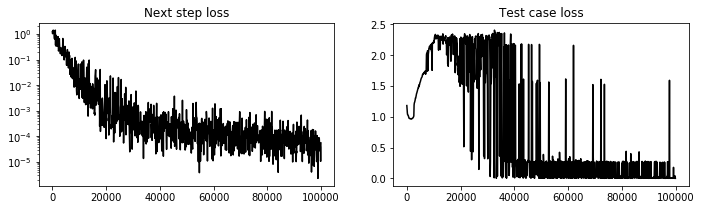

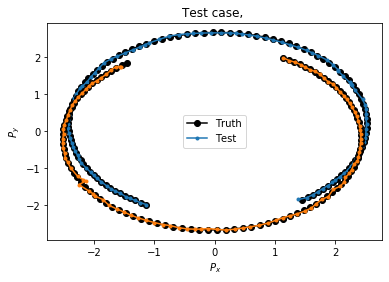

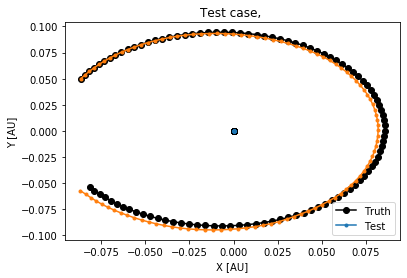

"\n  plot_trajectories(\n      true_trajectory_real, \n      real_trajectories[i][:,:,:], \n      name = 'Real case, ',\n      iteration = plot_every_iterations*i)\n"

In [0]:
#@title Visualize trajectories  { form-width: "30%" }

fig = plt.figure(1, figsize=(18, 3))
fig.clf()
x = np.array(logged_iterations)
# Next-step Loss.
y = losses_tr
ax = fig.add_subplot(1, 3, 1)
ax.plot(x, y, "k")
ax.set_yscale('log')
ax.set_title("Next step loss")
# Test case Loss.
y = losses_test
ax = fig.add_subplot(1, 3, 2)
ax.plot(x, y, "k")
#ax.set_yscale('log')
ax.set_title("Test case loss")
# Real case Loss.
#y = losses_real
#ax = fig.add_subplot(1, 3, 3)
#ax.set_yscale('log')
#ax.plot(x, y, "k")
#ax.set_title("Real case loss")
plt.savefig('losses.pdf')

# Visualize trajectories.
true_rollouts_test = get_node_trajectories(test_values["true_rollout_test"],
                                        batch_size_ge)[0]

predicted_rollouts_test = get_node_trajectories(test_values["predicted_rollout_test"],
                                        batch_size_ge)[0]

true_velocities_test = get_node_velocities(test_values["true_rollout_test"],
                                        batch_size_ge)[0]

predicted_velocities_test = get_node_velocities(test_values["predicted_rollout_test"],
                                        batch_size_ge)[0]

plot_trajectories(
      true_velocities_test[:,:2,:], 
      predicted_velocities_test[:,:2,:],
      name = 'Test case, ',
      iteration = plot_every_iterations*i, momenta = True, 
      savename = '1traj_mom')

plot_trajectories(
      true_rollouts_test[:,:2,:], 
      predicted_rollouts_test[:,:2,:],
      name = 'Test case, ',
      iteration = plot_every_iterations*i,
      savename = '1traj_pos')


'''
  plot_trajectories(
      true_trajectory_real, 
      real_trajectories[i][:,:,:], 
      name = 'Real case, ',
      iteration = plot_every_iterations*i)
'''


In [0]:


from google.colab import files
files.download('1traj_mom.pdf')
files.download('1traj_pos.pdf') 

Dimesn

# Testing

This part is used for testing parts of the code

In [0]:
#@title Generate & plot a graph

M_TO_AU = 1/(149.6e6 * 1000)
KG_TO_SOLM = 5.02785e-31
S_TO_Y = 3.17098e-8
DAY = 1/365.25

G = 6.67430e-11 #Gravitational Constant (m^3/s^2/kg)
G*= M_TO_AU**3./S_TO_Y**2./KG_TO_SOLM#(AU^3/y3^2/M_sun)

# Test with sun & Mercury only
# Sun
sun = Body()
sun.name = 'Sun'
sun.mass = 1 # solar masses
sun.initiate(0,0)

mercury = Body()
mercury.name = 'Mercury'
mercury.mass = 0.33011 * 10**24*KG_TO_SOLM # solar mases
pos_mercury = 0.387 # AU
vel_mercury = 47.36 * 1000*M_TO_AU/S_TO_Y # AU/Y
mercury.initiate(pos_mercury, vel_mercury)

planets = [sun, mercury]
graph_dict = base_graph(planets)
graphs_tuple_tf = utils_tf.data_dicts_to_graphs_tuple([graph_dict])

with tf.Session() as sess:
  graphs_tuple_np = sess.run(graphs_tuple_tf)
  print(graphs_tuple_np.globals[0])

plot_graphs_tuple_np(graphs_tuple_np)

In [0]:
#@title Plot some of the training orbits

norbits_plot = 5

with tf.Session() as sess: 
  traj = true_trajectory_tr.eval()
  learned_traj = predicted_nodes_rollout_test.eval()

j =0 
for i in range(norbits_plot):
  ind_low = j
  j+=+num_planets_tr[i]+1
  ind_high = j
  traj_plot = traj[:,ind_low:ind_high,1:3]
  learned_plot = learned_traj[:,ind_low:ind_high,1:3]
  plot_trajectories(traj_plot, learned_plot)

In [0]:
#@title More plots and visualizing things

plt.plot(true_velocities_test[:,1,0],true_velocities_test[:,1,1])
plt.plot(true_velocities_test[:,0,0],true_velocities_test[:,0,1])

true_velocities_test[0,0,:]
predicted_velocities_test[:,1,0]
np.mean(np.sum((predicted_velocities_test[:,1,0]-true_velocities_test[:,1,0])**2.))
np.mean(np.sum((true_velocities_test[:,1,0])**2.))
